In [1]:
import pandas as pd

data_resampled = pd.read_csv("../ECG_DATASET/dataset_ekg_resampled_no_outliers.csv")
data_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,target
0,-0.064515,-0.059515,-0.029515,-0.019515,-0.014515,-0.014515,-0.019515,-0.009515,0.020485,0.030485,...,0.125485,0.130485,0.120485,0.110485,0.110485,0.120485,0.135485,0.130485,0.115485,NSR
1,0.245485,0.250485,0.240485,0.230485,0.240485,0.240485,0.250485,0.235485,0.215485,0.220485,...,0.390485,0.375485,0.375485,0.385485,0.370485,0.355485,0.340485,0.335485,0.315485,NSR
2,0.130485,0.125485,0.110485,0.100485,0.105485,0.115485,0.120485,0.095485,0.090485,0.085485,...,-0.139515,-0.144515,-0.164515,-0.159515,-0.169515,-0.189515,-0.204515,-0.204515,-0.204515,NSR
3,-0.499515,-0.409515,-0.394515,-0.419515,-0.469515,-0.504515,-0.559515,-0.589515,-0.614515,-0.639515,...,-0.694515,-0.709515,-0.699515,-0.689515,-0.669515,-0.684515,-0.694515,-0.694515,-0.674515,NSR
4,0.245485,0.265485,0.255485,0.250485,0.230485,0.235485,0.245485,0.280485,0.270485,0.275485,...,0.115485,0.110485,0.120485,0.130485,0.140485,0.135485,0.120485,0.110485,0.120485,NSR


In [2]:
data_resampled.target.value_counts()

target
NSR          269
Bigeminy     267
Trigeminy    232
Name: count, dtype: int64

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Limpiar GPU
torch.cuda.empty_cache()

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Hiperparámetros
LATENT_DIM = 64
NUM_CLASSES = 3
SIGNAL_LENGTH = 3600
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001
KL_WEIGHT = 0.1  # Weight para KL divergence

# Mapeo de clases
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(data_resampled['target'].unique()))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
print(f"Mapeo de clases: {class_to_idx}")

# Normalizar datos entre -1 y 1
X = data_resampled.drop(columns=['target']).values.astype(np.float32)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min + 1e-7) - 1

# Dataset personalizado
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx])
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear dataset y dataloader
labels = data_resampled['target'].map(class_to_idx).values
dataset = ECGDataset(X_normalized, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset creado con {len(dataset)} muestras")

# ============= CONDITIONAL VAE =============
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, num_classes, signal_length):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.signal_length = signal_length
        
        # Embedding de clase
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        
        # ========== ENCODER ==========
        self.encoder = nn.Sequential(
            nn.Linear(signal_length + latent_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        
        # Salidas del encoder: media y log-varianza
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # ========== DECODER ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Linear(2048, signal_length),
            nn.Tanh()
        )
    
    def encode(self, x, labels):
        # Embeddings de clase
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        
        # Concatenar señal con embedding
        x_cond = torch.cat([x, label_emb], dim=1)
        h = self.encoder(x_cond)
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z, labels):
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        
        z_cond = torch.cat([z, label_emb], dim=1)
        x_recon = self.decoder(z_cond)
        return x_recon
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar
    
    def generate(self, num_samples, class_idx, device):
        """Genera nuevas señales sintéticas"""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        labels = torch.full((num_samples,), class_idx, dtype=torch.long).to(device)
        
        with torch.no_grad():
            samples = self.decode(z, labels)
        
        return samples

# Inicializar modelo
model = ConditionalVAE(LATENT_DIM, NUM_CLASSES, SIGNAL_LENGTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("✅ Modelo ConditionalVAE inicializado correctamente")
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")

# Función de pérdida VAE
def vae_loss(x_recon, x_original, mu, logvar, kl_weight=0.1):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_recon, x_original, reduction='mean')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    
    return total_loss, recon_loss, kl_loss

Usando dispositivo: cuda
Mapeo de clases: {'Bigeminy': 0, 'NSR': 1, 'Trigeminy': 2}
Dataset creado con 768 muestras
✅ Modelo ConditionalVAE inicializado correctamente
Total params: 20,276,048
✅ Modelo ConditionalVAE inicializado correctamente
Total params: 20,276,048



🚀 Iniciando entrenamiento del Conditional VAE...


Epoch 20/300 - Loss: 0.0541, Recon: 0.0461, KL: 0.0800


Epoch 40/300 - Loss: 0.0459, Recon: 0.0390, KL: 0.0692


Epoch 60/300 - Loss: 0.0426, Recon: 0.0358, KL: 0.0679


Epoch 80/300 - Loss: 0.0417, Recon: 0.0357, KL: 0.0597


Epoch 100/300 - Loss: 0.0389, Recon: 0.0354, KL: 0.0343


Epoch 120/300 - Loss: 0.0305, Recon: 0.0282, KL: 0.0223


Epoch 140/300 - Loss: 0.0298, Recon: 0.0276, KL: 0.0227


Epoch 160/300 - Loss: 0.0290, Recon: 0.0267, KL: 0.0225


Epoch 180/300 - Loss: 0.0292, Recon: 0.0270, KL: 0.0225


Epoch 200/300 - Loss: 0.0289, Recon: 0.0265, KL: 0.0230


Epoch 220/300 - Loss: 0.0286, Recon: 0.0263, KL: 0.0227


Epoch 240/300 - Loss: 0.0286, Recon: 0.0261, KL: 0.0243


Epoch 260/300 - Loss: 0.0283, Recon: 0.0258, KL: 0.0252


Epoch 280/300 - Loss: 0.0283, Recon: 0.0259, KL: 0.0239


Epoch 300/300 - Loss: 0.0281, Recon: 0.0256, KL: 0.0248


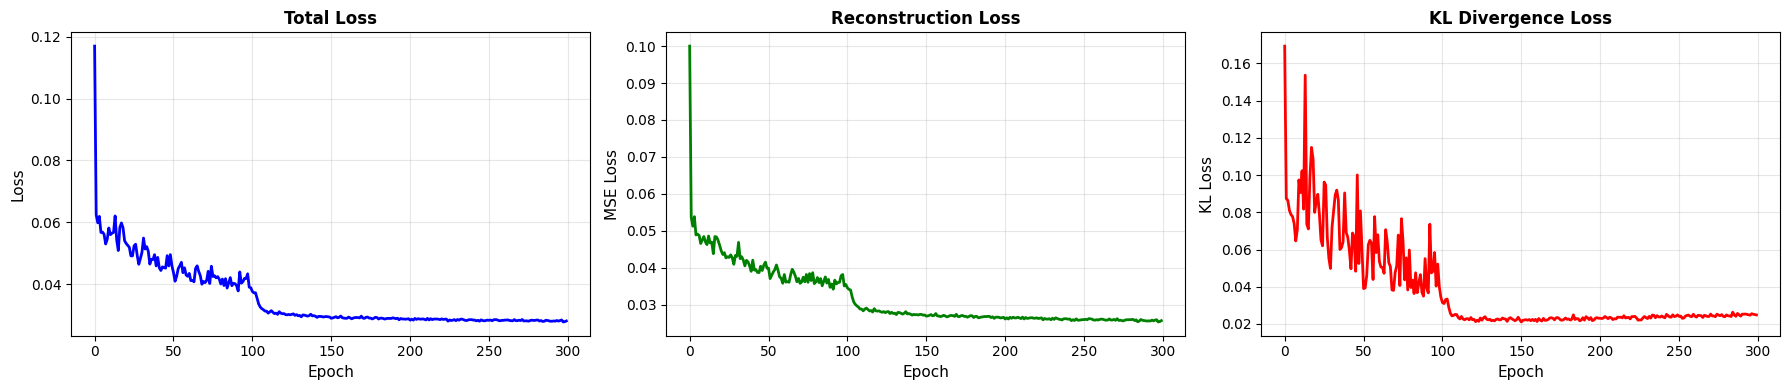


✅ Entrenamiento completado


In [4]:
# ============= ENTRENAMIENTO VAE =============
def train_vae(epochs):
    train_losses = []
    recon_losses = []
    kl_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        num_batches = 0
        
        for signals, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            signals = signals.to(device)
            labels = labels.to(device).squeeze()
            
            # Forward pass
            x_recon, mu, logvar = model(signals, labels)
            
            # Compute loss
            loss, recon, kl = vae_loss(x_recon, signals, mu, logvar, KL_WEIGHT)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon.item()
            epoch_kl += kl.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        avg_recon = epoch_recon / num_batches
        avg_kl = epoch_kl / num_batches
        
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")
    
    return train_losses, recon_losses, kl_losses

# Entrenar modelo
print("\n🚀 Iniciando entrenamiento del Conditional VAE...")
train_losses, recon_losses, kl_losses = train_vae(EPOCHS)

# Graficar pérdidas
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(train_losses, linewidth=2, color='blue')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Total Loss', fontsize=12, fontweight='bold')

axes[1].plot(recon_losses, linewidth=2, color='green')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('MSE Loss', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Reconstruction Loss', fontsize=12, fontweight='bold')

axes[2].plot(kl_losses, linewidth=2, color='red')
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('KL Loss', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].set_title('KL Divergence Loss', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Entrenamiento completado")

🔄 Generando señales sintéticas con VAE...
✅ Se generaron 150 señales sintéticas


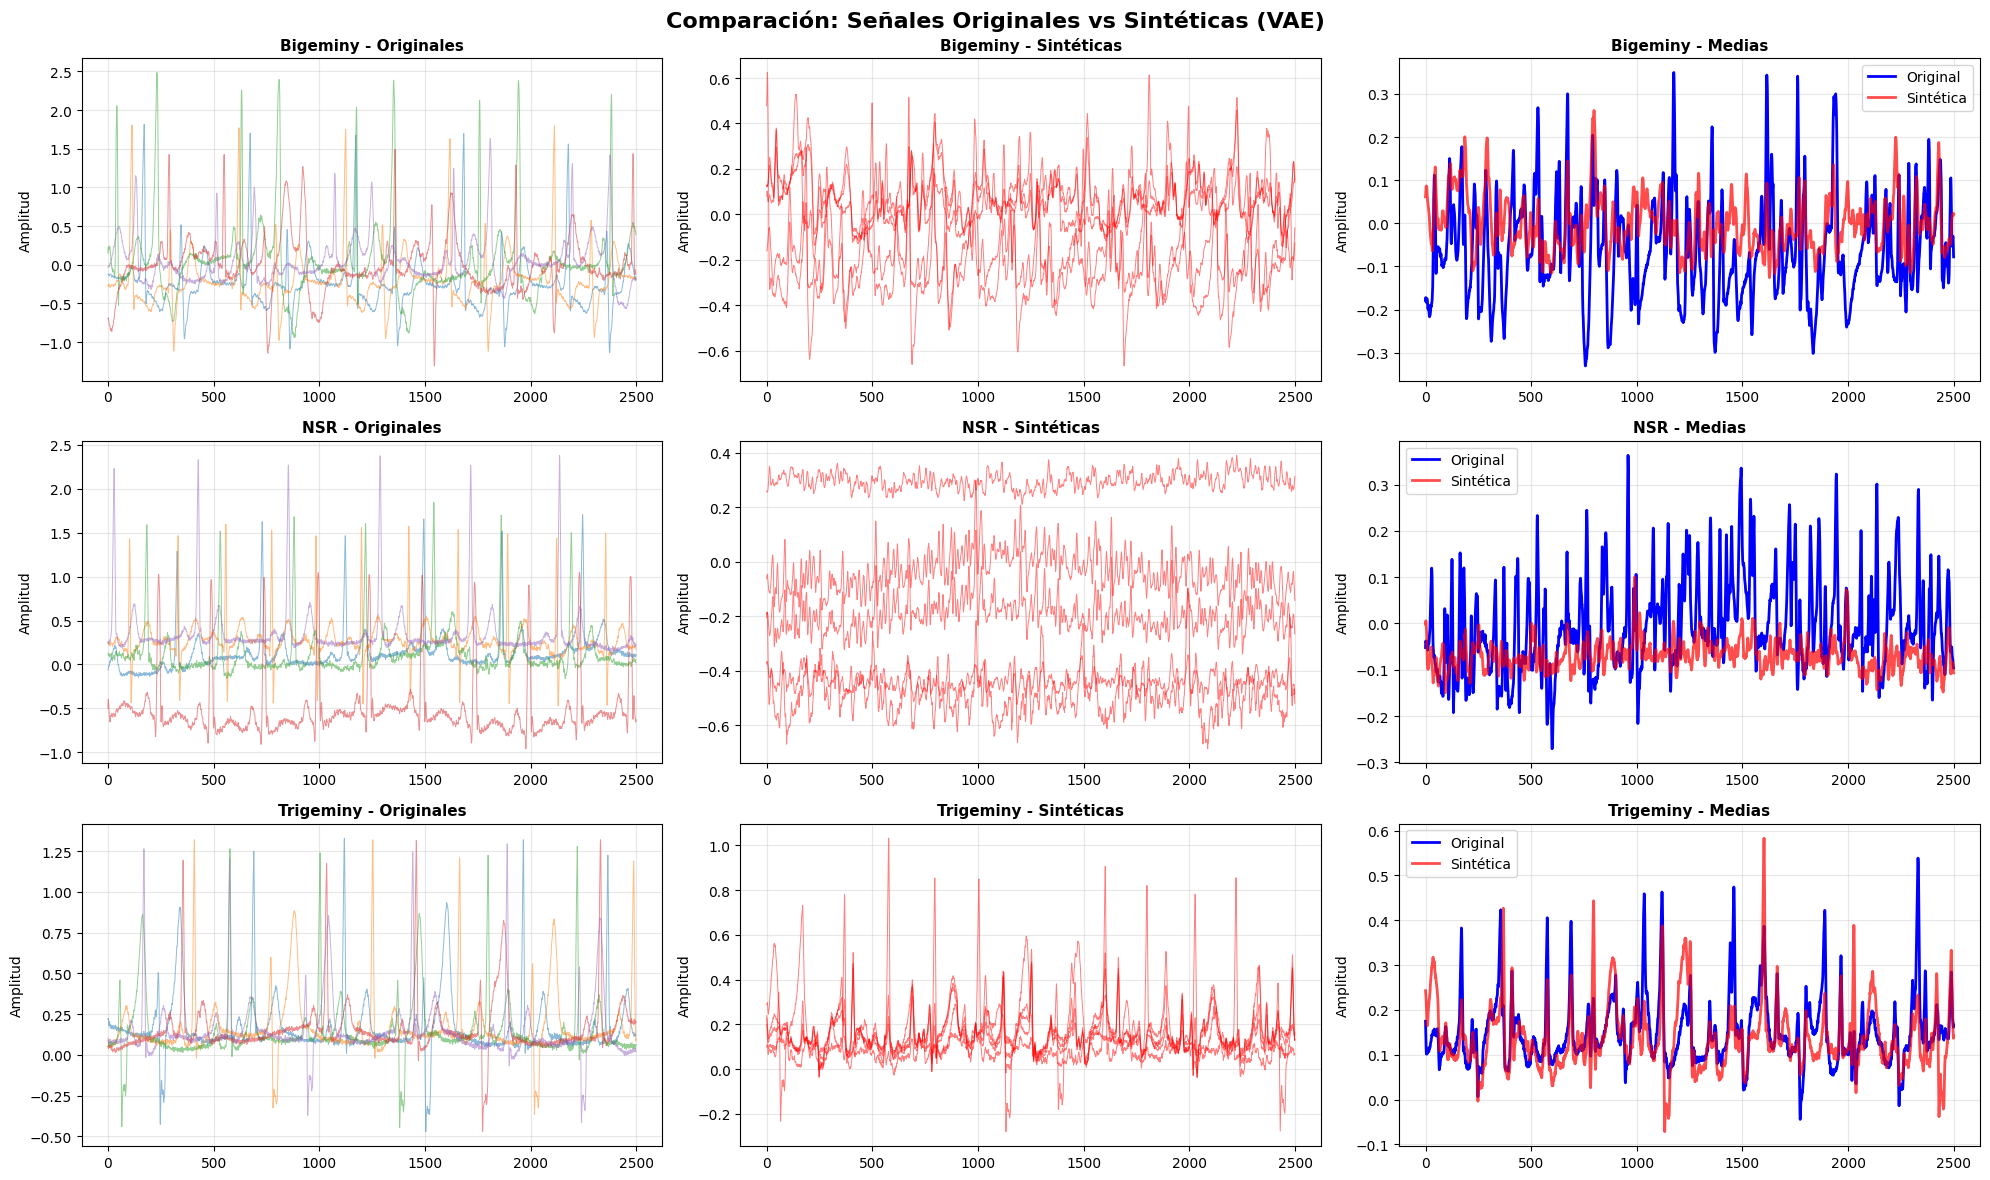


ANÁLISIS ESTADÍSTICO COMPARATIVO DETALLADO

Bigeminy:
  MEDIA:       Original = -0.01977  |  Sintética = -0.02046  |  Diferencia =  0.00069
  STD:         Original =  0.34638  |  Sintética =  0.20441  |  Diferencia =  0.14197
  MIN:         Original = -1.74418  |  Sintética = -1.11121  |  Diferencia =  0.63297
  MAX:         Original =  2.89582  |  Sintética =  2.27520  |  Diferencia =  0.62062
  CORRELACIÓN (primeros 500): 0.9495

NSR:
  MEDIA:       Original =  0.01811  |  Sintética =  0.00586  |  Diferencia =  0.01225
  STD:         Original =  0.42847  |  Sintética =  0.24983  |  Diferencia =  0.17864
  MIN:         Original = -1.55951  |  Sintética = -0.81824  |  Diferencia =  0.74127
  MAX:         Original =  2.94049  |  Sintética =  0.69285  |  Diferencia =  2.24763
  CORRELACIÓN (primeros 500): 0.7070

Trigeminy:
  MEDIA:       Original =  0.14795  |  Sintética =  0.14513  |  Diferencia =  0.00282
  STD:         Original =  0.16419  |  Sintética =  0.10037  |  Diferencia =  0

In [5]:
# ============= GENERAR SEÑALES SINTÉTICAS =============
def generate_synthetic_signals_vae(num_samples_per_class=50):
    """Genera señales sintéticas usando VAE"""
    model.eval()
    synthetic_data = []
    
    with torch.no_grad():
        for class_idx, class_name in idx_to_class.items():
            samples = model.generate(num_samples_per_class, class_idx, device)
            samples = samples.cpu().numpy()
            
            for signal_norm in samples:
                # Desnormalizar: convertir de [-1, 1] a rango original
                signal = (signal_norm + 1) / 2 * (X_max - X_min) + X_min
                
                synthetic_data.append({
                    'signal': signal,
                    'class': class_name,
                    'class_idx': class_idx
                })
    
    return synthetic_data

# Generar señales
print("🔄 Generando señales sintéticas con VAE...")
synthetic_signals = generate_synthetic_signals_vae(num_samples_per_class=50)
print(f"✅ Se generaron {len(synthetic_signals)} señales sintéticas")

# ============= VISUALIZACIÓN COMPARATIVA =============
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
fig.suptitle('Comparación: Señales Originales vs Sintéticas (VAE)', fontsize=16, fontweight='bold')

for class_idx, class_name in idx_to_class.items():
    orig_signals = X[labels == class_idx]
    synth_signals = np.array([s['signal'] for s in synthetic_signals if s['class'] == class_name])
    
    # Columna 1: Señales originales
    ax1 = axes[class_idx, 0]
    for i in range(min(5, len(orig_signals))):
        ax1.plot(orig_signals[i][:2500], alpha=0.5, linewidth=0.7)
    ax1.set_title(f'{class_name} - Originales', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Amplitud')
    
    # Columna 2: Señales sintéticas
    ax2 = axes[class_idx, 1]
    for i in range(min(5, len(synth_signals))):
        ax2.plot(synth_signals[i][:2500], alpha=0.5, linewidth=0.7, color='red')
    ax2.set_title(f'{class_name} - Sintéticas', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Amplitud')
    
    # Columna 3: Comparación de medias
    ax3 = axes[class_idx, 2]
    mean_orig = orig_signals[:min(10, len(orig_signals))].mean(axis=0)
    mean_synth = synth_signals[:min(10, len(synth_signals))].mean(axis=0)
    ax3.plot(mean_orig[:2500], linewidth=2, label='Original', color='blue')
    ax3.plot(mean_synth[:2500], linewidth=2, label='Sintética', color='red', alpha=0.7)
    ax3.set_title(f'{class_name} - Medias', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

# ============= ANÁLISIS ESTADÍSTICO DETALLADO =============
print("\n" + "="*80)
print("ANÁLISIS ESTADÍSTICO COMPARATIVO DETALLADO")
print("="*80)

comparison_data = []
for class_idx, class_name in idx_to_class.items():
    orig_signals = X[labels == class_idx]
    synth_signals = np.array([s['signal'] for s in synthetic_signals if s['class'] == class_name])
    
    # Estadísticas
    orig_mean = orig_signals.mean()
    synth_mean = synth_signals.mean()
    orig_std = orig_signals.std()
    synth_std = synth_signals.std()
    orig_min = orig_signals.min()
    synth_min = synth_signals.min()
    orig_max = orig_signals.max()
    synth_max = synth_signals.max()
    
    print(f"\n{class_name}:")
    print(f"  MEDIA:       Original = {orig_mean:8.5f}  |  Sintética = {synth_mean:8.5f}  |  Diferencia = {abs(orig_mean - synth_mean):8.5f}")
    print(f"  STD:         Original = {orig_std:8.5f}  |  Sintética = {synth_std:8.5f}  |  Diferencia = {abs(orig_std - synth_std):8.5f}")
    print(f"  MIN:         Original = {orig_min:8.5f}  |  Sintética = {synth_min:8.5f}  |  Diferencia = {abs(orig_min - synth_min):8.5f}")
    print(f"  MAX:         Original = {orig_max:8.5f}  |  Sintética = {synth_max:8.5f}  |  Diferencia = {abs(orig_max - synth_max):8.5f}")
    
    # Calcular correlación
    mean_orig = orig_signals.mean(axis=0)
    mean_synth = synth_signals.mean(axis=0)
    correlation = np.corrcoef(mean_orig[:500], mean_synth[:500])[0, 1]
    print(f"  CORRELACIÓN (primeros 500): {correlation:.4f}")
    
    comparison_data.append({
        'class': class_name,
        'orig_mean': orig_mean,
        'synth_mean': synth_mean,
        'orig_std': orig_std,
        'synth_std': synth_std,
        'correlation': correlation
    })

print("\n" + "="*80)

In [ ]:
# ============= CREAR DATAFRAME Y GUARDAR =============
print("\n📁 Guardando señales sintéticas...")

# Convertir a DataFrame
synthetic_df = pd.DataFrame({
    'signal': [str(s['signal'].tolist()) for s in synthetic_signals],
    'class': [s['class'] for s in synthetic_signals],
    'class_idx': [s['class_idx'] for s in synthetic_signals]
})

# Guardar
output_path = '../../data/synthetic_signals_vae.csv'
#synthetic_df.to_csv(output_path, index=False)
print(f"✅ Señales guardadas en: {output_path}")
print(f"   Total: {len(synthetic_df)} señales")
print(f"   Distribución por clase:")
print(synthetic_df['class'].value_counts())

# Guardar modelo
model_path = '../resultados/vae_model_final.pth'
#torch.save(model.state_dict(), model_path)
print(f"\n✅ Modelo VAE guardado en: {model_path}")

# Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL DE SÍNTESIS CON VAE")
print("="*80)
print(f"✅ Modelo entrenado: {EPOCHS} epochs")
print(f"✅ Señales generadas: {len(synthetic_signals)}")
print(f"✅ Clases: {list(idx_to_class.values())}")
print(f"✅ Longitud señal: {SIGNAL_LENGTH} samples")
print(f"✅ Dataset salvado: {output_path}")
print(f"✅ Modelo salvado: {model_path}")
print("="*80)


📁 Guardando señales sintéticas...
✅ Señales guardadas en: ../../data/synthetic_signals_vae.csv
   Total: 150 señales
   Distribución por clase:
class
Bigeminy     50
NSR          50
Trigeminy    50
Name: count, dtype: int64
✅ Señales guardadas en: ../../data/synthetic_signals_vae.csv
   Total: 150 señales
   Distribución por clase:
class
Bigeminy     50
NSR          50
Trigeminy    50
Name: count, dtype: int64


RuntimeError: Parent directory ../resultados does not exist.

In [ ]:
sin1 = synthetic_signals[0]["signal"]
plt.plot(sin1)
plt.xlim(0,2500)

In [ ]:
# Guardar modelos
print("Guardando modelos...")
#torch.save(generator.state_dict(), 'generator_cgan_ecg.pth')
#torch.save(discriminator.state_dict(), 'discriminator_cgan_ecg.pth')
print("Modelos guardados correctamente")

# Crear DataFrame con señales sintéticas
synthetic_df_list = []
for sample in synthetic_signals:
    row = {'target': sample['class']}
    signal_values = sample['signal']
    # Agregar cada valor de la señal como una columna
    for i, val in enumerate(signal_values):
        row[i] = val
    synthetic_df_list.append(row)

synthetic_df = pd.DataFrame(synthetic_df_list)
print(f"\nDataFrame de señales sintéticas creado")
print(f"Shape: {synthetic_df.shape}")
print(f"Distribución de clases:\n{synthetic_df['target'].value_counts()}")

# Guardar DataFrame
#synthetic_df.to_csv('../ECG_DATASET/synthetic_signals_cgan.csv', index=False)
#print("\nSeñales sintéticas guardadas en: ../ECG_DATASET/synthetic_signals_cgan.csv")

# Mostrar ejemplo
print("\nEjemplo de datos sintéticos:")
synthetic_df.head()